# Inferring parameters for the ToR-ORd model

In this notebook, we use PINTS to create noisy data for a ToR-ORd [$^{[1]}$](#Sources) system and then perform inference on the model
to try and retrieve the parameters. This should be compared with results from other notebooks, such as the FitzHugh-Nagumo and Beeler-Reuter
notebooks.

## Creating the ForwardModel

### Variable descriptions

We need to set up the ODE system first. This is a large system and so we will not go through all the equations and varibles,
but we will give a description of all the currents and fluxes in the model and the important parameters (to be inferred).

|variable|description|ions|
|---|-------|---|
|$V$|membrane potential|all|
|$I_{Na}$|fast sodium current|$Na^{+}$|
|$I_{NaL}$|late sodium current|$Na^{+}$|
|$I_{to}$|transient outward potassium current|$K^{+}$|
|$I_{CaL}$|L-type calcium current|$Ca^{2+}$|
|$I_{K_r}$|rapid delayed rectifier potassium current|$K^{+}$|
|$I_{K_s}$|slow delayed rectifier potassium current|$K^{+}$|
|$I_{K_1}$|inward rectifier current|$K^{+}$|
|$I_{NaCa}$|sodium/calcium exchanger (NCX)|$Na^{+}$, $Ca^{2+}$|
|$I_{NaK}$|sodium/potassium pump|$Na^{+}$, $K^{+}$|
|$I_{Kb}$|background potassium current|$K^{+}$|
|$I_{Nab}$|background sodium current|$Na^{+}$|
|$I_{Cab}$|background calcium current|$Ca^{2+}$|
|$I_{pCa}$|calcium pump|$Ca^{2+}$|
|$I_{ClCa}$|calcium-sensitive chloride current|$Cl^{-}$|
|$I_{Clb}$|background chloride current|$Cl^{-}$|
|$J_{rel}$|calcium flux through ryanodine receptor|$Ca^{2+}$|
|$J_{up}$|calcium uptake into network sarcoplasmic reticulum via SERCA|$Ca^{2+}$|
|$J_{leak}$|calcium leak out of network sarcoplasmic reticulum|$Ca^{2+}$|
|$J_{tr}$|calcium NSR to JSR calcium translocation|$Ca^{2+}$|
|$J_{diff,Na}$|sodium diffusion flux between myoplasm and subspace|$Na^{+}$|
|$J_{diff,K}$|potassium diffusion flux between myoplasm and subspace|$K^{+}$|
|$J_{diff}$|calcium diffusion flux between myoplasm and subspace|$Ca^{2+}$|
|CMDN|calmodulin buffer|$Ca^{2+}$|
|TRPN|troponin buffer|$Ca^{2+}$|
|CSQN|calsequestrin buffer|$Ca^{2+}$|
|BSR|anionic sarcoplasmic reticulum binding sites for calcium|$Ca^{2+}$|
|BSL|anionic sarcolemmal binding sites for calcium|$Ca^{2+}$|
|CaMKII|calmodulin-dependent protein kinase II|$Ca^{2+}$|

We will not go into any major detail with the equations, but the main membrane potential ODE is a sum of all the above
currents added to a stimulating current, $I_{stim}$ which provides the action potential shape. We also note here that the
ToR-ORd model has $43$ time dependent variables forming a system of $43$ ordinary differential equations.

|variable group|list of variables|ions|
|---|---|---|
|Membrane potential|$V$|all|
|Ion compartment concentrations|$[Na]_{i}, [Na]_{ss}, [K]_{i}, [K]_{ss}, [Ca]_{i}, [Ca]_{ss}, [Ca]_{nsr}, [Ca]_{jsr}$|$Na^{+}, K^{+}, Ca^{2+}$|
|$I_{Na}$ gating variables|$m, h_{p}, h, j, j_{p}$|$Na^{+}$|
|$I_{NaL}$ gating variables|$m_L, h_L, h_{Lp}$|$Na^{+}$|
|$I_{to}$ gating variables|$a, i_{F}, i_{S}, a_{p}, i_{Fp}, i_{Sp}$|$K^{+}$|
|$I_{CaL}$ gating variables|$d, f_{f}, f_{s}, f_{caf}, f_{cas}, j_{ca}, n_{ca}, n_{cai}, f_{fp}, f_{cafp}$|$K^{+}$|
|$I_{K_r}$ gating variables|$C_{0}, C_{1}, C_{2}, O, I$|$K^{+}$|
|$I_{K_s}$ gating variables|$x_{s1}, x_{s2}$|$K^{+}$|
|$J_{rel}$|$J_{relp}, J_{relnp}$|$Ca^{2+}$|
|CaMKII buffer|$CaMK_{t}$|$Ca^{2+}$|

### Initial conditions

We will use the following initial conditions, representing an endocardial cell.

In [1]:
initial_conditions = [-88.8691566357934,12.0996647655188,12.1000028563765,142.412524737626,142.412481425842,7.45541572746214e-05,
                      6.50418928341426e-05,1.53037019085812,1.52803094224238,0.000787657400526199,0.674096901201792,0.830658198588696,
                      0.830466744399495,0.830093612199637,0.000159670117055769,0.528261721740178,0.288775833197764,0.000944249645410894,
                      0.999616956857814,0.593680589620082,0.000481107253796778,0.999616964658062,0.654092074678260,8.86091322819384e-29,
                      0.999999992783113,0.938965241412012,0.999999992783179,0.999900458262832,0.999977476316330,0.000492094765239740,
                      0.000833711885764158,0.999999992566681,0.999999992766279,0.247156543918935,0.000175017075236424,3.90843796133124e-24,
                      0.0110752904836162,0.998073652444028,0.000844745297078649,0.000698171876592920,0.000370404872169913,1.30239063420973e-05,
                      -1.88428892080206e-22]

In [16]:
import pints
import numpy as np
import scipy.integrate as si
import nbkode
import matplotlib.pyplot as plt

from torord_rhs import ToRORdRHS

### PINTS implementation of the model

In addition to implementing the system, we give the option in the class to specify fixed parameters, if we wish to 
reduce the dimensions of the parameter space. Additionally, as we realistically would only be able to measure the membrane potential,
$V$, and the calcium concentration, $c$, we will use these as the only outputs of the system.

The system of equations from the model have been adapted from the original MATLAB code from the ToR-ORd github repository [$^{[5]}$](#Sources).

In [145]:
class ToRORdModel(pints.ForwardModel):

    def __init__(self, initial_conditions, stimulating_current, fixed_params=None, outputs=["V", "c"],
                 rtol=10**(-3), atol=10**(-6)):
        """Initialises the forward model with certain fixed parameters passed to the method
        as key-value pairs.
        """
        super(ToRORdModel, self).__init__()
        assert len(initial_conditions) == 43
        self._initial_conditions = initial_conditions
        # The current conditions represent the state of the model after one beat
        self._current_conditions = initial_conditions
        self._reset_model = True

        assert len(stimulating_current) == 2
        self._stim_duration, self._stim_amplitude = tuple(stimulating_current)
        self._param_names = ["G_Na", "P_Cab", "G_Kr", "G_ClCa", "G_Clb"]
        self._variable_names = ["V", "Na_i", "Na_ss", "K_i", "K_ss", "Ca_i", "Ca_ss", "Ca_nsr", "Ca_jsr",
                                "m", "hp", "h", "j", "jp",
                                "mL", "hL", "hLp",
                                "a", "iF", "iS", "ap", "iFp", "iSp",
                                "d", "ff", "fs", "fcaf", "fcas", "jca", "nca", "nca_i", "ffp", "fcafp",
                                "xs1", "xs2",
                                "Jrel_np", "CaMKt",
                                "ikr_c0", "ikr_c1", "ikr_c2", "ikr_o", "ikr_i",
                                "Jrel_p"]
        self._fixed_params = {}
        if fixed_params is not None:
            for k in fixed_params.keys():
                if k in self._param_names:
                    self._fixed_params[k] = fixed_params[k]

        assert 1 <= len(outputs) <= 43
        assert set(outputs).issubset(set(self._variable_names))
        self._outputs = outputs
        self._rtol = rtol
        self._atol = atol
        # If we wish to specific current or flux multipliers, we do so in the dict below (e.g. for blocking channels)
        self.multipliers = {"I_CaL": 1, "I_Na": 1, "I_to": 1, "I_NaL": 1, "I_Kr": 1, "I_Ks": 1, "I_K1": 1, "I_Kb": 1,
                             "I_NaCa": 1, "I_NaK": 1, "I_Nab": 1, "I_Cab": 1, "I_pCa": 1, "I_CaCl": 1, "I_Clb": 1,
                             "J_rel": 1, "J_up": 1}
        # If we wish to change the extracellular concentrations or subspace fractions, we do so here
        self.concs_and_fractions = {"Na_o": 140.0, "Ca_o": 1.8, "K_o": 5.0, "ICaL_fractionSS": 0.8, "INaCa_fractionSS": 0.35}

    def get_param_names(self):
        """Returns the parameter names.
        """
        return self._param_names

    def get_unfixed_param_names(self):
        """Returns the unfixed parameters
        """
        output_list = self._param_names.copy()
        for fixed_param in self._fixed_params.keys():
            output_list.remove(fixed_param)
        return output_list

    def n_outputs(self):
        """Returns number of model outputs, default to just V and c
        """
        return len(self._outputs)

    def n_parameters(self):
        """Returns number of parameters to be inferred, i.e. all non-fixed parameters.
        """
        return len(self._param_names) - len(self._fixed_params)

    def n_fixed_parameters(self):
        """Returns number of parameters we fix.
        """
        return len(self._fixed_params)

    def simulate(self, parameters, times):
        """This inherits from pints.ForwardModel, performs one forward simulation of the model.
        The list `parameters` contains only the parameters we are inferring.
        """
        G_Na, P_Cab, G_Kr, G_ClCa, G_Clb = self._get_all_params(parameters)
        t_span = [times[0], times[len(times) - 1]]
        
        # For the line below, our starting state will either be the true initial conditions,
        # or the conditions of the model at the end of the last heartbeat
        y0 = self._initial_conditions if self._reset_model else self._current_conditions
        sol = si.odeint(func=self._rhs, y0=y0, t=times, 
                        args=(G_Na, P_Cab, G_Kr, G_ClCa, G_Clb,
                              self._stim_duration, self._stim_amplitude, 
                              self.multipliers, self.concs_and_fractions),
                        rtol=self._rtol, atol=self._atol)
        # Update the current conditions
        self._current_conditions = sol[-1, :]

        # Now we find which outputs we wish to use
        output_indices = [self._variable_names.index(variable) for variable in self._outputs]
        return np.array([sol[:, index] for index in output_indices]).transpose()

    def simulate_beats(self, parameters, times, num_beats, num_saved_beats=1):
        """This method imitates how ToR-ORd is initially run, by starting with some arbitrary initial conditions
        and then simulating a number of beats to get the model into an oscillatory state. This is the only time
        in which reset_model flag is set to False, as we wish for a continuous set of beats.
        """
        self._reset_model = False
        output_list = []
        for beat in range(num_beats):
            print(beat, end='--^v--')
            data = self.simulate(parameters, times)
            if num_beats - beat <= num_saved_beats:
                output_list.append(data)
        self._reset_model = True
        return np.vstack(output_list)

    def _get_all_params(self, parameters):
        """We need a list of 5 parameters, so we check to see which parameters are fixed, and which are not.
        We increment j each time a non-fixed parameter is reached.
        """
        all_parameters = []
        j = 0
        for param in self._param_names:
            if param in self._fixed_params.keys():
                all_parameters.append(self._fixed_params[param])
            else:
                all_parameters.append(parameters[j])
                j += 1
        return tuple(all_parameters)

    @staticmethod
    def _rhs(y, t, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, stim_duration, stim_amplitude, multipliers, concs_and_fractions):
        """The right hand side function of the ToR-ORd system. This is in a separate file as it is 
        a very long system of equations.
        """
        rhs = ToRORdRHS(t, y, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, stim_duration, stim_amplitude, multipliers, concs_and_fractions)
        return np.array(rhs.evaluate())

<>:103: SyntaxWarning: invalid escape sequence '\_'
<>:103: SyntaxWarning: invalid escape sequence '\_'
C:\Users\matth\AppData\Local\Temp\ipykernel_9000\1508668006.py:103: SyntaxWarning: invalid escape sequence '\_'
  print(beat, end='_/\_')


## Generating data for the model

### Simulating the system

All of the currents have corresponding conductances, and the fluxes have corresponding multipliers. The conductances we will
be most interested in for the purpose of inference are listed in the table below.

|conductance|ToR-ORd value [$^{[1]}$](#Sources)|ion|reasoning for inference|
|---|---|---|-------|
|$G_{Na}$|$11.7802$|$Na^{+}$|Multiple changes were made: the Grandi [$^{[2]}$](#Sources) model was used with ORd [$^{[3]}$](#Sources) CaMKII phosphorylation.|
|$P_{Cab}$|$8.3757 \times 10^{-5}$|$Ca^{2+}$|The L-type calcium current had the largest revision of them all compared to the ORd model.|
|$G_{K_r}$|$0.0321$|$K^{+}$|This was changed to have a Markovian [$^{[4]}$](#Sources) formulation, as originally parameter inference could not fit the action potential.|
|$G_{ClCa}$|$0.2843$|$Cl^{-}$|This current was added for the purpose of fitting to the shape of the action potential.|
|$G_{Clb}$|$0.00198$|$Cl^{-}$|This current was added for the purpose of fitting to the shape of the action potential.|

Next, we will generate some data for the model using known parameter values. We will use the final parameter values achieved by
Tomek et al. [$^{[1]}$](#Sources) in the table above. Additionally, we will use their stimulation parameters of `stim_amplitude = -53` and
`stim_duration = 1`.

In [131]:
# Here we choose which parameters to fix in the simulation
fixed_params = {"G_Na": 11.7802, "G_Clb": 0.00198}
# fixed_params = None
# Stimulation parameters [stim_duration, stim_amplitude]
stim_params = [1, -53]

In [146]:
model = ToRORdModel(initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
param_names = model.get_unfixed_param_names()
print(param_names)
parameters = np.array([8.3757e-5, 0.0321, 0.2843])
times = np.arange(0, 1000, 2)

['P_Cab', 'G_Kr', 'G_ClCa']


In [112]:
data = model.simulate(parameters, times)

In [7]:
import pandas as pd

In [113]:
output_param_df = pd.DataFrame({"true": parameters})

### Adding noise to the system

We now utilise PINTS noise generators to create some noisy data for the system. Specifically, `pints.noise.independent`
creates independent Gaussian noise iid $\mathcal{N}(0, \sigma)$.

In [114]:
sigma = np.array([1, 3e-6])
noisy_data = data + pints.noise.independent(sigma, data.shape)

### Plotting time series and phase plane

In [10]:
import matplotlib.pyplot as plt

In [115]:
noisy_df = pd.DataFrame(noisy_data, columns=["V", "Ca_i"])
noisy_df.to_csv("simulation_outputs/noisy_data.csv")

In [116]:
noisy_data = pd.read_csv("simulation_outputs/noisy_data.csv", index_col=0).to_numpy()
# noisy_V = noisy_data[:, 0]
V, Ca = data[:, 0], data[:, 1]

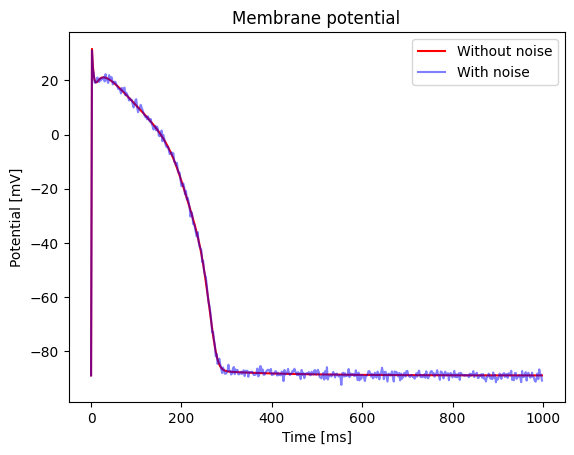

In [117]:
# V = data[:, 0]
noisy_V, noisy_Ca = noisy_data[:, 0], noisy_data[:, 1]
plt.plot(times, V, "-r", label="Without noise")
plt.plot(times, noisy_V, "-b", alpha=0.5, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title("Membrane potential")
plt.savefig("simulation_outputs/time_series_V.png")

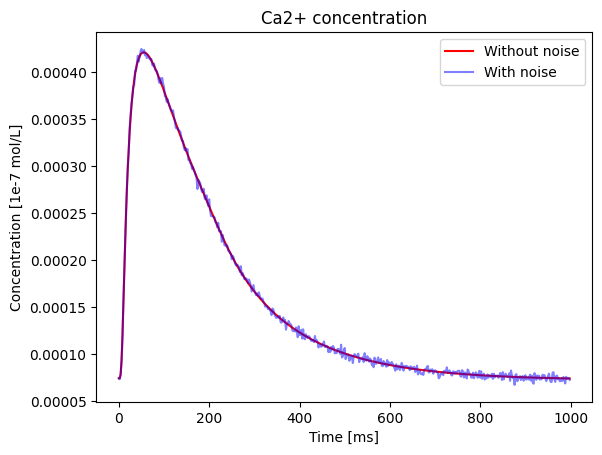

In [118]:
plt.plot(times, Ca, "-r", label="Without noise")
plt.plot(times, noisy_Ca, "-b", alpha=0.5, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.legend()
plt.title("Ca2+ concentration")
plt.savefig("simulation_outputs/time_series_c.png")

### Simulating multiple beats

Our model also has the ability to simulate multiple continuous beats, as in the original ToR-ORd model [$^{[5]}$](#Sources). We will do this for $100$ beats
and then plot the last $5$ as a demonstration.

In [147]:
multiple_beats_data = model.simulate_beats(parameters, times, num_beats=100, num_saved_beats=5)

0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_20_/\_21_/\_22_/\_23_/\_24_/\_25_/\_26_/\_27_/\_28_/\_29_/\_30_/\_31_/\_32_/\_33_/\_34_/\_35_/\_36_/\_37_/\_38_/\_39_/\_40_/\_41_/\_42_/\_43_/\_44_/\_45_/\_46_/\_47_/\_48_/\_49_/\_50_/\_51_/\_52_/\_53_/\_54_/\_55_/\_56_/\_57_/\_58_/\_59_/\_60_/\_61_/\_62_/\_63_/\_64_/\_65_/\_66_/\_67_/\_68_/\_69_/\_70_/\_71_/\_72_/\_73_/\_74_/\_75_/\_76_/\_77_/\_78_/\_79_/\_80_/\_81_/\_82_/\_83_/\_84_/\_85_/\_86_/\_87_/\_88_/\_89_/\_90_/\_91_/\_92_/\_93_/\_94_/\_95_/\_96_/\_97_/\_98_/\_99_/\_

In [148]:
multiple_beats_df = pd.DataFrame(multiple_beats_data, columns=["V", "Ca_i"])
multiple_beats_df.to_csv("simulation_outputs/multiple_beats.csv")

In [149]:
multiple_beats_data = pd.read_csv("simulation_outputs/multiple_beats.csv", index_col=0).to_numpy()
mult_V, mult_Ca = multiple_beats_data[:, 0], multiple_beats_data[:, 1]

In [150]:
mult_times = np.arange(0, 5000, 2)

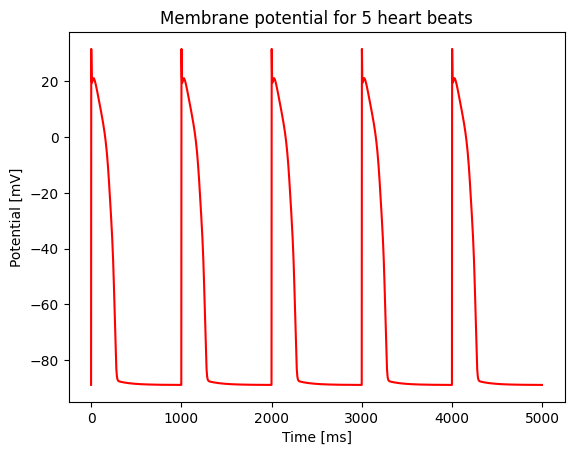

In [151]:
plt.plot(mult_times, mult_V, "-r")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.title("Membrane potential for 5 heart beats")
plt.savefig("simulation_outputs/multiple_beats_V.png")

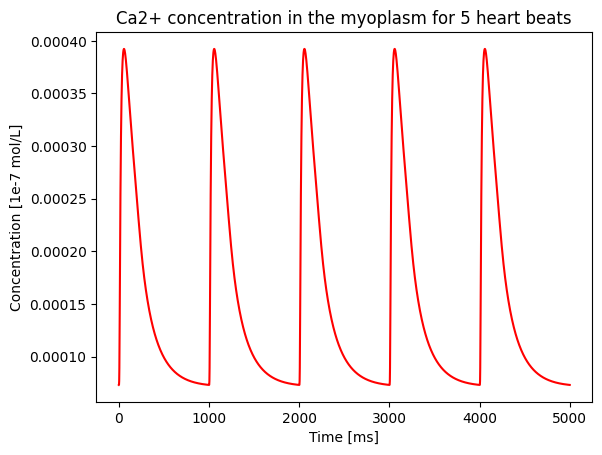

In [152]:
plt.plot(mult_times, mult_Ca, "-r")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.title("Ca2+ concentration in the myoplasm for 5 heart beats")
plt.savefig("simulation_outputs/multiple_beats_Ca.png")

## Using PINTS to perform inference

We will now perform Bayesian inference on the model to try and recover the values of the input parameters. Here, we use the CMAES-ACMC
combination by optimising the problem first to find starting parameters with CMAES and then using ACMC to perform Bayesian inference
on the parameters.

### Optimisation using `pints.CMAES`

We first use the optimiser to reach some realistic parameter values for the noisy data.

In [119]:
problem = pints.MultiOutputProblem(model, times, noisy_data)
score = pints.SumOfSquaresError(problem)

Next, choose some boundaries for the parameters. We will bound them within a $100$ magnitude range.

In [120]:
boundaries = pints.RectangularBoundaries([1e-6, 1e-3, 1e-2],
                                         [1e-4, 1e-1, 1])
log_prior = pints.UniformLogPrior(boundaries)

C:\Users\matth\AppData\Local\Temp\ipykernel_9000\212984883.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(boundaries)


In [121]:
num_opts = 10

And here we perform the optimisation. We choose to run this `num_opts` times to try and find the optimal solution of the different
optimised parameters. Each optimisation is deemed complete if the objective function has not changed by more than $10^{-8}$ over a
period of $200$ iterations. We save the parameters from each optimisation to a .csv file.

In [124]:
for j in range(1, num_opts):
    xs = log_prior.sample(1)
    # sigma = [0.1, 0.001, 0.1, 0.01, 0.01, 0.01, 1, 1, 1, 1, 1, 1, 1]
    # transform = pints.RectangularBoundariesTransformation(boundaries)
    opt = pints.OptimisationController(score, xs, boundaries=boundaries, method=pints.CMAES)
    opt.set_max_unchanged_iterations(200, 0.00000001)
    opt.set_max_iterations(1000)
    opt_params, opt_values = opt.run()
    opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
    opt_param_df.to_csv(f"optimisation_outputs/lca_kr_cl/opt_params_{j}.csv")

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7      318166.6  318166.6   0:13.0
1     14     311436.4  311436.4   0:25.3

----------------------------------------
Unexpected termination.
Current score: 311436.4422437777
Current position:
 9.73029850680813698e-05
 9.50059575496074310e-02
 7.29317427621668957e-01
----------------------------------------


KeyboardInterrupt: 

In [123]:
opt_params = opt.optimiser().x_best()
import pandas as pd
opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
opt_param_df.to_csv(f"optimisation_outputs/lca_kr_cl/opt_params_{1}.csv")

## Sources

$^{[1]}$ J. Tomek *et al.*, Development, calibration, and validation of a novel human ventricular myocyte model in health, disease, and drug block, eLife **8** (2019), e48890, https://doi.org/10.7554/eLife.48890.

$^{[2]}$ E. Grandi *et al.*, A Novel Computational Model of the Human Ventricular Action Potential and Ca Transient, J. Mol. Cell Cardiol. **48** (2010), pp. 112, https://pubmed.ncbi.nlm.nih.gov/19835882/.

$^{[3]}$ T. O’Hara *et al.*, Simulation of the Undiseased Human Cardiac Ventricular Action Potential: Model Formulation and Experimental 
Validation, PLoS Comput. Biol.** **7 (2011), e100206, https://doi.org/10.1371/journal.pcbi.10020611.

$^{[4]}$ Y. Lu *et al.*, Effects of premature stimulation on HERG K+ channels **537** (2001), pp. 843-851, https://pubmed.ncbi.nlm.nih.gov/11744759/.

$^{[5]}$ J. Tomek, Repository for the cardiac model ToR-ORd, Github, 4ffab13, https://github.com/jtmff/torord. Date first accessed: 2024-04-22. 